<h1><div style="text-align: center"> Phishing Website Detector </div></h1> 

The dataset is from UCI Repository(https://archive.ics.uci.edu/ml/datasets/phishing+websites#).<br />
It has 11055 instances and 31 attributes(=features) including the label, <b>Result</b>. The description on these attributes is on the website above.<br />
Some of the attributes are url length, age of domain, whether domain name is separated by the dash(-) symbol.<br />
<b>Result</b> is either 1 or -1 and the other 30 attributes are among -1, 0, and 1.<br />

<h3>(1) Data preprocessing</h3>
The numbers in the original dataset are not integer type, so we had to preprocess the dataset.<br />

<h3>(2) Feature selection</h3>
We had difficulty in getting all 30 attributes in the dataset.<br />
So we measured the importance of each feature and tried to get the important features first.<br />
After all we used the 11 features that we were able to get among the most important features.<br />

<h3>(3) Correlation between the features</h3>
Because the feature values are among -1, 0, and 1, it was easy to see the correlation between the features.<br />
Especially seeing the <b>Result</b> column below, we could see how each attribute was correlated to <b>Result</b>.<br />
Prefix_Suffix, having_Sub_Domain, URL_of_Anchor were positively correlated to <b>Result</b>.<br />

<h3>(4) Training-test dataset split</h3>
To get accuracy from the model, we split the dataset into training set(67%) and the test set(33%).<br />
After measuring the accuracy, we will make a new model with the whole dataset, in order to increase the accuracy to the real data.<br />

<h3>(5) Model selection</h3>
We tried some basic classifiers including Decision Tree, KNN and MLP first, and then tried some more complex classifiers including RandomForest, AdaBoost, and voting classifier.<br />
The latter are called ensemble classifiers which are a combination of different classifiers. They are usually more powerful than other basic classifiers.<br />
Voting classifier is the classifier we used for our final model.<br />

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from scipy.io import arff

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

import tensorflow as tf

%matplotlib inline

In [2]:
data, meta = arff.loadarff("phishingdataset.arff")

<h3>(1) Data preprocessing</h3>

In [3]:
data = pd.DataFrame(data)
data = data.astype(str)
r = {"b'1'": '1', "b'-1'": '-1', "b'0'": '0'}
data = data.replace(r)
data = data.astype(int)

X = data.iloc[:,:-1] # features
y = data.iloc[:,-1]  # class

In [4]:
data.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [5]:
X.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,1,-1,-1,-1,-1,1,1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,1,-1,-1,0,-1,1,1,1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,1,-1,1,-1,1,0,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,1,-1,-1,1,-1,1,-1,1
4,1,0,-1,1,1,-1,1,1,-1,1,...,1,-1,1,-1,-1,0,-1,1,1,1


<h3>(2) Feature selection</h3>

In [6]:
rf_for_emb = RandomForestClassifier()      
rf_for_emb = rf_for_emb.fit(X, y)
importances = rf_for_emb.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_for_emb.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. URL_of_Anchor (0.300594)
2. SSLfinal_State (0.298838)
3. web_traffic (0.073366)
4. having_Sub_Domain (0.059822)
5. Links_in_tags (0.044369)
6. Prefix_Suffix (0.023269)
7. Links_pointing_to_page (0.018241)
8. Request_URL (0.018214)
9. SFH (0.017234)
10. age_of_domain (0.015983)
11. Domain_registeration_length (0.013423)
12. Google_Index (0.012619)
13. DNSRecord (0.012305)
14. having_IP_Address (0.011518)
15. Page_Rank (0.009678)
16. URL_Length (0.008367)
17. HTTPS_token (0.006794)
18. having_At_Symbol (0.006735)
19. Statistical_report (0.006367)
20. Submitting_to_email (0.005795)
21. Abnormal_URL (0.005267)
22. Redirect (0.004855)
23. Favicon (0.004592)
24. popUpWidnow (0.004580)
25. Shortining_Service (0.004576)
26. on_mouseover (0.003488)
27. double_slash_redirecting (0.002995)
28. Iframe (0.002665)
29. port (0.001929)
30. RightClick (0.001522)


In [7]:
data = data[['having_IP_Address','URL_Length','having_At_Symbol','Shortining_Service','double_slash_redirecting','Prefix_Suffix','having_Sub_Domain','HTTPS_token','URL_of_Anchor','age_of_domain','Page_Rank','Result']]

X = data.iloc[:,:-1] # features
y = data.iloc[:,-1]  # class

In [8]:
X.head()

,having_IP_Address,URL_Length,having_At_Symbol,Shortining_Service,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,HTTPS_token,URL_of_Anchor,age_of_domain,Page_Rank
0,-1,1,1,1,-1,-1,-1,-1,-1,-1,-1
1,1,1,1,1,1,-1,0,-1,0,-1,-1
2,1,0,1,1,1,-1,-1,-1,0,1,-1
3,1,0,1,1,1,-1,-1,-1,0,-1,-1
4,1,0,1,-1,1,-1,1,1,0,-1,-1


<h3> (3) Correlation between the features</h3>

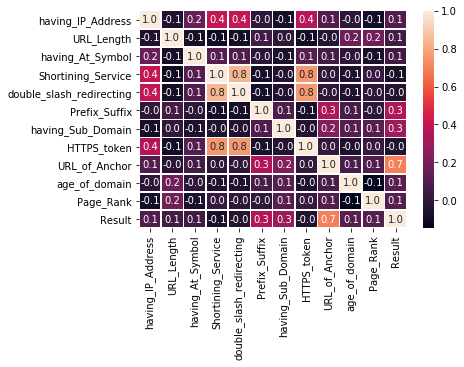

In [9]:
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt='.1f')

<h3>(4) Training-test dataset split</h3>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# X_train = (7406, 11), X_test = (3649, 11)

<h3>(5) Model selection</h3>

In [11]:
# Model Selection 1 (Basic classifiers)

# (1) Decision Trees

dt0 = tree.DecisionTreeClassifier()
dt0.fit(X_train, y_train)
print("Decision tree :", dt0.score(X_test, y_test))

dt1 = tree.DecisionTreeClassifier(min_samples_leaf=4)
dt1.fit(X_train, y_train)
print("Decision tree, min_samples_leaf = 4 :", dt1.score(X_test, y_test))

dt2 = tree.DecisionTreeClassifier(min_samples_leaf=6)
dt2.fit(X_train, y_train)
print("Decision tree, min_samples_leaf = 6 :", dt2.score(X_test, y_test))
print()


# (2) KNN

knn0 = KNeighborsClassifier(n_neighbors = 18)
knn0.fit(X_train, y_train)
print("KNN, K=18 :", knn0.score(X_test, y_test))

knn1 = KNeighborsClassifier(n_neighbors = 25)
knn1.fit(X_train, y_train)
print("KNN, K=25 :", knn1.score(X_test, y_test))
print()


# (3) MLP

mlp0 = MLPClassifier(hidden_layer_sizes=(15, 15))
mlp0.fit(X_train, y_train)
print("MLP, (15, 15) :", mlp0.score(X_test, y_test))

mlp1 = MLPClassifier(hidden_layer_sizes=(15, 15, 15))
mlp1.fit(X_train, y_train)
print("MLP, (15, 15, 15) :", mlp1.score(X_test, y_test))

mlp2 = MLPClassifier(hidden_layer_sizes=(20, 20))
mlp2.fit(X_train, y_train)
print("MLP, (20, 20) :", mlp2.score(X_test, y_test))

mlp3 = MLPClassifier(hidden_layer_sizes=(30, 30))
mlp3.fit(X_train, y_train)
print("MLP, (30, 30) :", mlp3.score(X_test, y_test))
print()


# (4) SVM
svc0 = SVC()
svc0.fit(X_train, y_train)
print("SVM :", svc0.score(X_test, y_test))
print()


# (5) Neural Network
onehoty_train = pd.get_dummies(y_train, prefix='Result', columns=['Result'])
onehoty_test = pd.get_dummies(y_test, prefix='Result', columns=['Result'])

n_nodes_input = 11 # number of input features
n_nodes_hl = 11     # number of units in a hidden layer
n_classes = 2       # classes
a = tf.placeholder('float', [None, 11])
b = tf.placeholder('float')

def neural_network_model(data):
    # define weights and biases for all each layer
    hidden_layer = {'weights':tf.Variable(tf.truncated_normal([n_nodes_input, n_nodes_hl], stddev=0.3)),
                      'biases':tf.Variable(tf.constant(0.1, shape=[n_nodes_hl]))}
    output_layer = {'weights':tf.Variable(tf.truncated_normal([n_nodes_hl, n_classes], stddev=0.3)),
                    'biases':tf.Variable(tf.constant(0.1, shape=[n_classes]))}
    # feed forward and activations
    l1 = tf.add(tf.matmul(data, hidden_layer['weights']), hidden_layer['biases'])
    l1 = tf.nn.sigmoid(l1)
    output = tf.matmul(l1, output_layer['weights']) + output_layer['biases']
    
    return output

def train_neural_network(a):
    prediction = neural_network_model(a)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=b,logits=prediction))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    for epoch in range(1000):
        loss = 0
        _, c = sess.run([optimizer, cost], feed_dict = {a: X_train, b: onehoty_train})
        loss += c
        if (epoch % 100 == 0 and epoch != 0):
            print('Epoch', epoch, 'completed out of', 1000, 'Training loss:', loss)
    correct = tf.equal(tf.argmax(prediction,1), tf.argmax(b,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='op_accuracy')
    
    print('Train set Accuracy:', sess.run(accuracy, feed_dict = {a: X_train, b: onehoty_train}))
    print('Test set Accuracy:', sess.run(accuracy, feed_dict = {a: X_test, b: onehoty_test}))
    
train_neural_network(a)

Decision tree : 0.8799671142778843
Decision tree, min_samples_leaf = 4 : 0.8755823513291313
Decision tree, min_samples_leaf = 6 : 0.8769525897506166

KNN, K=18 : 0.8646204439572486
KNN, K=25 : 0.8648944916415456

MLP, (15, 15) : 0.8821594957522609
MLP, (15, 15, 15) : 0.8780487804878049
MLP, (20, 20) : 0.8859961633324198
MLP, (30, 30) : 0.8862702110167169

SVM : 0.8851740202795286

Epoch 100 completed out of 1000 Training loss: 0.639824390411377
Epoch 200 completed out of 1000 Training loss: 0.5855611562728882
Epoch 300 completed out of 1000 Training loss: 0.5258331298828125
Epoch 400 completed out of 1000 Training loss: 0.475236713886261
Epoch 500 completed out of 1000 Training loss: 0.4353886544704437
Epoch 600 completed out of 1000 Training loss: 0.40431588888168335
Epoch 700 completed out of 1000 Training loss: 0.3802022337913513
Epoch 800 completed out of 1000 Training loss: 0.36199402809143066
Epoch 900 completed out of 1000 Training loss: 0.34853559732437134
Train set Accuracy: 0

In [12]:
# Model Selection 2 (Ensemble)

# (1) RandomForest

RFclf0 = RandomForestClassifier()
RFclf0.fit(X_train, y_train)
print("RandomForest :", RFclf0.score(X_test, y_test))

RFclf1 = RandomForestClassifier(n_estimators = 20)
RFclf1.fit(X_train, y_train)
print("RandomForest, n_estimators=20 :", RFclf1.score(X_test, y_test))
print()
      
    
# (2) Bagging
      
bag0 = BaggingClassifier()
bag0.fit(X_train, y_train)
print("Bagging :", bag0.score(X_test, y_test))
      
bag1 = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3))
bag1.fit(X_train, y_train)
print("Bagging, base_estimator=KNN(k=3) :", bag1.score(X_test, y_test))
      
bag2 = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=28))
bag2.fit(X_train, y_train)
print("Bagging, base_estimator=KNN(k=28) :", bag2.score(X_test, y_test))
print()
      
    
# (3) AdaBoost
      
ABclf0 = AdaBoostClassifier() #n_estimators=50, learning_rate = 1
ABclf0.fit(X_train, y_train)
print("AdaBoost :", ABclf0.score(X_test, y_test))
      
ABclf1 = AdaBoostClassifier(n_estimators=200, learning_rate = 0.5)
ABclf1.fit(X_train, y_train)
print("AdaBoost, n_estimators=200, learning_rate=0.5 :", ABclf1.score(X_test, y_test))
      
ABclf2 = AdaBoostClassifier(n_estimators=400, learning_rate = 0.5)
ABclf2.fit(X_train, y_train)
print("AdaBoost, n_estimators=400, learning_rate=0.5 :", ABclf2.score(X_test, y_test))
print()

RandomForest : 0.8802411619621814
RandomForest, n_estimators=20 : 0.8843518772266374

Bagging : 0.8821594957522609
Bagging, base_estimator=KNN(k=3) : 0.8701013976431899
Bagging, base_estimator=KNN(k=28) : 0.8640723485886544

AdaBoost : 0.8553028226911482
AdaBoost, n_estimators=200, learning_rate=0.5 : 0.8555768703754453
AdaBoost, n_estimators=400, learning_rate=0.5 : 0.8547547273225541



In [13]:
# (4) Voting
voteclf1 = VotingClassifier(
    estimators=[('dt0', tree.DecisionTreeClassifier()), 
                ('mlp0', MLPClassifier(hidden_layer_sizes=(15, 15))),
                ('mlp3', MLPClassifier(hidden_layer_sizes=(30, 30))),
                ('RFclf1', RandomForestClassifier(n_estimators = 20)),
                ('bag0', BaggingClassifier())], 
    voting='soft')
voteclf1.fit(X_train, y_train)
print("Voting, DT & MLP & RF & BAGGING :", voteclf1.score(X_test, y_test))

Voting, DT & MLP & RF & BAGGING : 0.8879144971224994


C:\Users\user\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [14]:
# Prediction examples using KNN
#print(knn0.predict([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))
#print(knn0.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

C:\Users\user\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


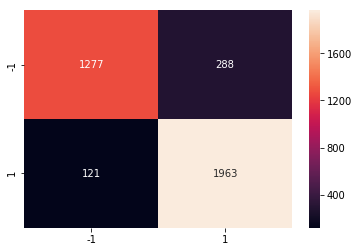

In [15]:
cm = confusion_matrix(y_test, voteclf1.predict(X_test), labels = [-1, 1])
sns.heatmap(cm, annot = True, fmt = "d", xticklabels = [-1, 1], yticklabels = [-1, 1])

In [16]:
voteclf1 = VotingClassifier(
    estimators=[('dt0', tree.DecisionTreeClassifier()), 
                ('mlp0', MLPClassifier(hidden_layer_sizes=(15, 15))),
                ('mlp3', MLPClassifier(hidden_layer_sizes=(30, 30))),
                ('RFclf1', RandomForestClassifier(n_estimators = 20)),
                ('bag0', BaggingClassifier())], 
    voting='soft')
voteclf1.fit(X, y) # Here we used all the instances to train a new model

VotingClassifier(estimators=[('dt0', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea...estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [17]:
dump(voteclf1, 'model.joblib')

['model.joblib']

In [ ]:
# from joblib import dump, load
# dump(clf, 'filename.joblib')
# clf = load('filename.joblib')